<a href="https://www.kaggle.com/code/pumpernickel/container-throughput-forcast?scriptVersionId=99320516" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Container forcast using raindom forest model

In this project, we aims the build a prediction model for container throughput in Thailand port. 

We first load all the data collected throughout year 2001-2021. This included inbound and outbound container throughput. As for the features, we use features as follows

- Consumer price index
- Export value
- Import value
- GDP constant
- Inflation rate
- Interest rate
- Manufacture product index
- Population
- Unemployment rate
- USD to THB conversion rate

Resources:

[Feature selection for random forest](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py)

[Random forest regression model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest%20regressor#sklearn.ensemble.RandomForestRegressor)

[Randomized search cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
from PIL import Image


# Loading label for model prediction

First, we read inbound and outbound throughput from file and convert month data to number (0-12)

In [2]:
month_to_int = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 
'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}


labels_df = pd.read_csv("../input/thai-container-throughput/container_throughput_label.csv")
labels_df['month'] = labels_df['month'].map(lambda x: month_to_int[x])

labels_df.head()


,year,month,inbound,outbound
0,2001,1,91751,82123
1,2001,2,83475,83014
2,2001,3,95149,95933
3,2001,4,86302,91967
4,2001,5,96431,101828


# Load features for model prediction

Similar to inbound and outbound value, we load all features and convert month to number

In [3]:
features_df = pd.read_csv("../input/thai-container-throughput/features.csv")
features_df = features_df.drop('id', axis=1)


features_df['month'] = features_df['month'].map(lambda x: month_to_int[x])
features_df = features_df.interpolate(axis=0)

features_df

,year,month,export_value,GDP_constant,import_value,inflation_percentage_change,interest_rate,manufac_prod_index,population,unemployment_rate,exchange_rate,consumer_price_index
0,2001,1,279973.0,459359.0,255061.0,0.72,2.50,52.47,62308887.0,5.73,43.12,68.8
1,2001,2,279973.0,459359.0,255061.0,0.44,2.00,53.02,62308887.0,4.25,42.64,69.1
2,2001,3,279973.0,459359.0,255061.0,0.00,2.00,52.18,62308887.0,4.04,43.90,69.1
3,2001,4,283056.0,442241.0,255379.0,0.72,2.00,51.29,62308887.0,4.06,45.46,69.6
4,2001,5,283056.0,442241.0,255379.0,0.29,2.00,52.51,62308887.0,4.24,45.48,69.8
...,...,...,...,...,...,...,...,...,...,...,...,...
247,2021,8,498456.0,893821.0,512104.0,0.15,0.25,96.28,66186727.0,1.49,30.09,99.7
248,2021,9,498456.0,893821.0,512104.0,0.15,0.25,96.28,66186727.0,1.49,30.09,99.7
249,2021,10,498456.0,893821.0,512104.0,0.15,0.25,96.28,66186727.0,1.49,30.09,99.7
250,2021,11,498456.0,893821.0,512104.0,0.15,0.25,96.28,66186727.0,1.49,30.09,99.7


# Feature exploration

In this section, heatmap chart is created to see a correlation between each feature. As a result, it looks like export_value, GDP_constant, import_value, manufac_prod_index, population, and consumer_price_index are highly correlate to each other.

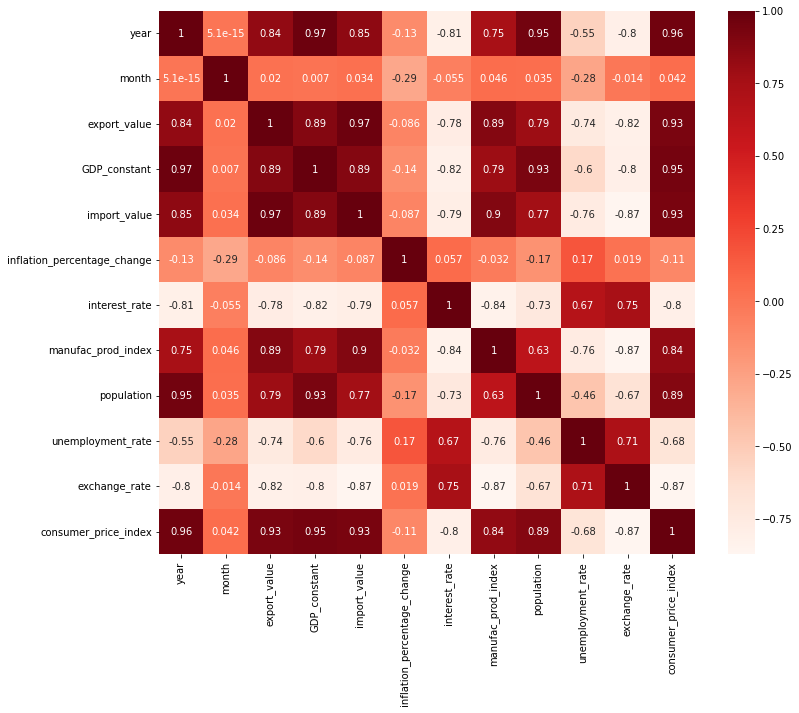

In [4]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = features_df.corr()
cor_map = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [5]:
# Store correlation map to file
fig = cor_map.get_figure()
fig.savefig("cor_map.png") 

## Generate Training and Testing set

In this section, we will generate a training set and testing set for performing model training in the next section. The data will be split into 25% test set and 75% training set

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance


First, we shift the data for 72 months for future forecasting

In [7]:
shifted_labels_df = labels_df.shift(-48)
shifted_labels_df = shifted_labels_df.drop(labels_df.tail(48).index)

shifted_features_df = features_df.drop(features_df.tail(48).index)

In [8]:
# Convert pandas dataframe to numpy array
feature_list = list(shifted_features_df.columns)
features = np.array(shifted_features_df)
labels = np.array(shifted_labels_df.drop(['year','month'], axis=1))
# Split data into training and testing set with 25% of test set
train_features, test_features, train_labels, test_labels = train_test_split(features, 
                                                            labels, test_size=0.25, random_state=42)


# Create Random forest model

In this section, a random forest model is created and parameter optimization is performed to find the best suitable parameter for the model

In [9]:
# Create set of parameters to perform parameter optimization
# n_estimators = [int(x) for x in np.linspace(500, 2000, num=5)]
n_estimators = [900]
max_features = ['log2', 'sqrt', None]
max_depth = [int(x) for x in np.linspace(1, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_state = [int(x) for x in np.linspace(0, 50, num=5)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state': random_state}

print("Set of parameter optimization: \n")
for key, val in random_grid.items():
    print(f"{key}: {val}")

Set of parameter optimization: 

n_estimators: [900]
max_features: ['log2', 'sqrt', None]
max_depth: [1, 25, 50, 75, 100, None]
min_samples_split: [2, 5, 10]
min_samples_leaf: [1, 2, 4]
bootstrap: [True, False]
random_state: [0, 12, 25, 37, 50]


## Train model

In [10]:
start_time = time.time()
# Random search of parameters, using 3 fold cross validation, 
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                            cv = 3, scoring = 'neg_mean_absolute_error', verbose=1, 
                            random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)
elapsed_time = time.time() - start_time

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [11]:
print("\nDone. Parameters are")
for key, val in rf_random.best_params_.items(): 
    print(f"{key}: {val}")
print(f"\nElapsed time to find best parameter: {elapsed_time:.3f} seconds")


Done. Parameters are
random_state: 25
n_estimators: 900
min_samples_split: 2
min_samples_leaf: 2
max_features: log2
max_depth: None
bootstrap: True

Elapsed time to find best parameter: 136.034 seconds


In [12]:
best_model = rf_random.best_estimator_
best_model.fit(train_features, train_labels)

RandomForestRegressor(max_features='log2', min_samples_leaf=2, n_estimators=900,
                      random_state=25)

# Feature importance

After the model is tuned and fitted to the training set, this section will explore how the model see a significant in each features and then we will compare to the correlation map above

## Mean decrease in impurity

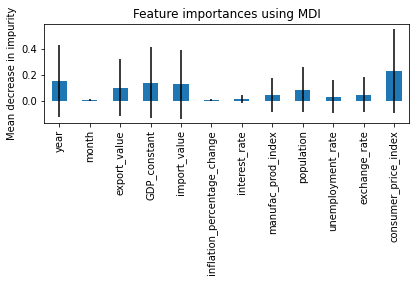

In [13]:
# Find feature importance variances for each tree in random forest

importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [14]:
fig.savefig('feature_importance_MDI.png')

## Permutation importance

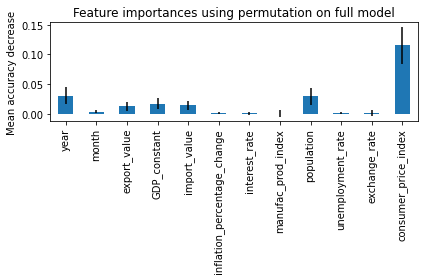

In [15]:
result = permutation_importance(
    best_model, test_features, test_labels, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [16]:
fig.savefig('feature_importance_perm.png')

Conclusion: It seems like the model sees a similiar trends of features correlation. Feature such as consumer_price_index, population, GDP_constant, export_value, import_value, and manufac_prod_index are able to recognize as important by model while other features like interest_rate and exchange_rate which contradict the correlation to features mentioned before is consider important as well.

# Evaluation of model

In this section, we would like to evaluate a forcasting result with feature selection and without it to see.

## Result without feature selection

In [17]:
predictions = best_model.predict(test_features)

In [18]:
# Print evaluation metric
print(f'Mean Absolute Error (MAE): {mean_absolute_error(test_labels, predictions)}')
print(f'Mean Squared Error (MSE): {mean_squared_error(test_labels, predictions)}')
print(f'Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(test_labels, predictions))}')
print(f'Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(test_labels, predictions)}')

Mean Absolute Error (MAE): 12928.664946044637
Mean Squared Error (MSE): 262998493.5645532
Root Mean Squared Error (RMSE): 16217.228294765822
Mean Absolute Percentage Error (MAPE): 0.052348564003628306


## Result with feature selection

In this experiment, inflation percentage changes and interest rate is exclude from model fitting to see the effect of feature selection

In [19]:
tr_features = train_features
te_features = test_features
tr_features = np.delete(tr_features, 5, 1)
tr_features = np.delete(tr_features, 6, 1)

te_features = np.delete(te_features, 5, 1)
te_features = np.delete(te_features, 6, 1)

best_model.fit(tr_features, train_labels)
new_predictions = best_model.predict(te_features)

In [20]:
print(f'Mean Absolute Error (MAE): {mean_absolute_error(test_labels, new_predictions)}')
print(f'Mean Squared Error (MSE): {mean_squared_error(test_labels, new_predictions)}')
print(f'Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(test_labels, new_predictions))}')
print(f'Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(test_labels, new_predictions)}')

Mean Absolute Error (MAE): 12954.248439899613
Mean Squared Error (MSE): 270644698.0546338
Root Mean Squared Error (RMSE): 16451.282565643134
Mean Absolute Percentage Error (MAPE): 0.05250310240138663


### Conclusion

By exclude these two features, we are able to reduce error in forecasting container throughput. This told us that these two features are a noise and effects the ability to forecast a container throughput

In [21]:
feature_list.remove('interest_rate')
feature_list.remove('inflation_percentage_change')

# Examine prediction result

In [22]:
prediction_df = pd.DataFrame(data={'year': map(int, test_features.T[0]+5), 'month': map(int, test_features.T[1]), 
                                   'inbound': new_predictions.T[0], 'outbound': new_predictions.T[1],
                                  'real_inbound': test_labels.T[0], 'real_outbound': test_labels.T[1],
                                  'difference_inbound': abs(new_predictions.T[0] - test_labels.T[0]), 
                                   'difference_outbound': abs(new_predictions.T[1] - test_labels.T[1])})
prediction_df = prediction_df.sort_values(by=['year','month'])
prediction_df

,year,month,inbound,outbound,real_inbound,real_outbound,difference_inbound,difference_outbound
1,2006,10,159395.715551,162732.709171,184182.0,173448.0,24786.284449,10715.290829
0,2007,4,169311.277757,170451.670530,156799.0,152475.0,12512.277757,17976.670530
25,2007,5,167499.957588,169004.768526,177236.0,190609.0,9736.042412,21604.231474
16,2007,7,175167.893372,179515.490180,182933.0,193063.0,7765.106628,13547.509820
48,2007,8,174584.515325,179009.477173,185207.0,185438.0,10622.484675,6428.522827
44,2008,1,186016.282740,185916.431746,183929.0,174984.0,2087.282740,10932.431746
47,2008,6,199753.268869,203831.804590,186276.0,192919.0,13477.268869,10912.804590
23,2008,7,204895.746834,209433.244759,207651.0,212348.0,2755.253166,2914.755241
43,2009,3,206712.734254,208706.488930,232010.0,240005.0,25297.265746,31298.511070
5,2009,10,190971.053142,189663.693261,225085.0,222791.0,34113.946858,33127.306739


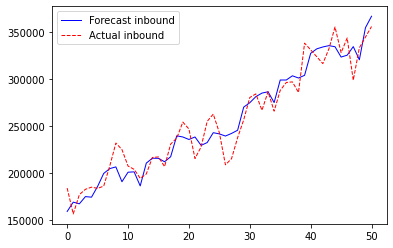

In [23]:
fig, ax = plt.subplots()

ax.plot(np.arange(0,prediction_df['year'].count()), prediction_df['inbound'], 'b', linewidth=1.0, label='Forecast inbound')
ax.plot(np.arange(0,prediction_df['year'].count()), prediction_df['real_inbound'], 'r--', linewidth=1.0, label='Actual inbound')
ax.legend()
plt.show()
fig.savefig('forecast_vs_actual_inbound.png')

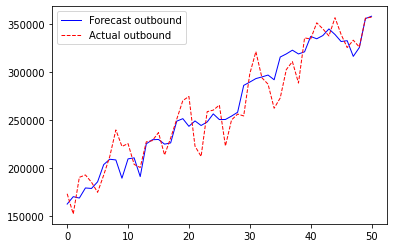

In [24]:
fig, ax = plt.subplots()

ax.plot(np.arange(0,prediction_df['year'].count()), prediction_df['outbound'], 'b', linewidth=1.0, label='Forecast outbound')
ax.plot(np.arange(0,prediction_df['year'].count()), prediction_df['real_outbound'], 'r--', linewidth=1.0, label='Actual outbound')
ax.legend()
plt.show()
fig.savefig('forecast_vs_actual_outbound.png')

### Minimum difference between real inbound throughput and forcast inbound througput

In [25]:
prediction_df.loc[prediction_df['difference_inbound'] == prediction_df['difference_inbound'].min()]

,year,month,inbound,outbound,real_inbound,real_outbound,difference_inbound,difference_outbound
32,2016,9,286460.040603,297137.467862,286538.0,287646.0,77.959397,9491.467862


### Maximum difference between real inbound throughput and forcast inbound througput

In [26]:
prediction_df.loc[prediction_df['difference_inbound'] == prediction_df['difference_inbound'].max()]

,year,month,inbound,outbound,real_inbound,real_outbound,difference_inbound,difference_outbound
9,2021,2,334392.272771,316607.372916,298753.0,333469.0,35639.272771,16861.627084


### Minimum difference between real outbound throughput and forcast outbound througput

In [27]:
prediction_df.loc[prediction_df['difference_outbound'] == prediction_df['difference_outbound'].min()]

,year,month,inbound,outbound,real_inbound,real_outbound,difference_inbound,difference_outbound
41,2022,8,354431.418939,355990.758365,344497.0,356412.0,9934.418939,421.241635


### Maximum difference between real outbound throughput and forcast outbound througput

In [28]:
prediction_df.loc[prediction_df['difference_outbound'] == prediction_df['difference_outbound'].max()]

,year,month,inbound,outbound,real_inbound,real_outbound,difference_inbound,difference_outbound
28,2017,4,298943.98101,315923.860109,287974.0,273296.0,10969.98101,42627.860109


In [29]:
prediction_df.to_csv('prediction.csv')

# Show a tree in Random forest

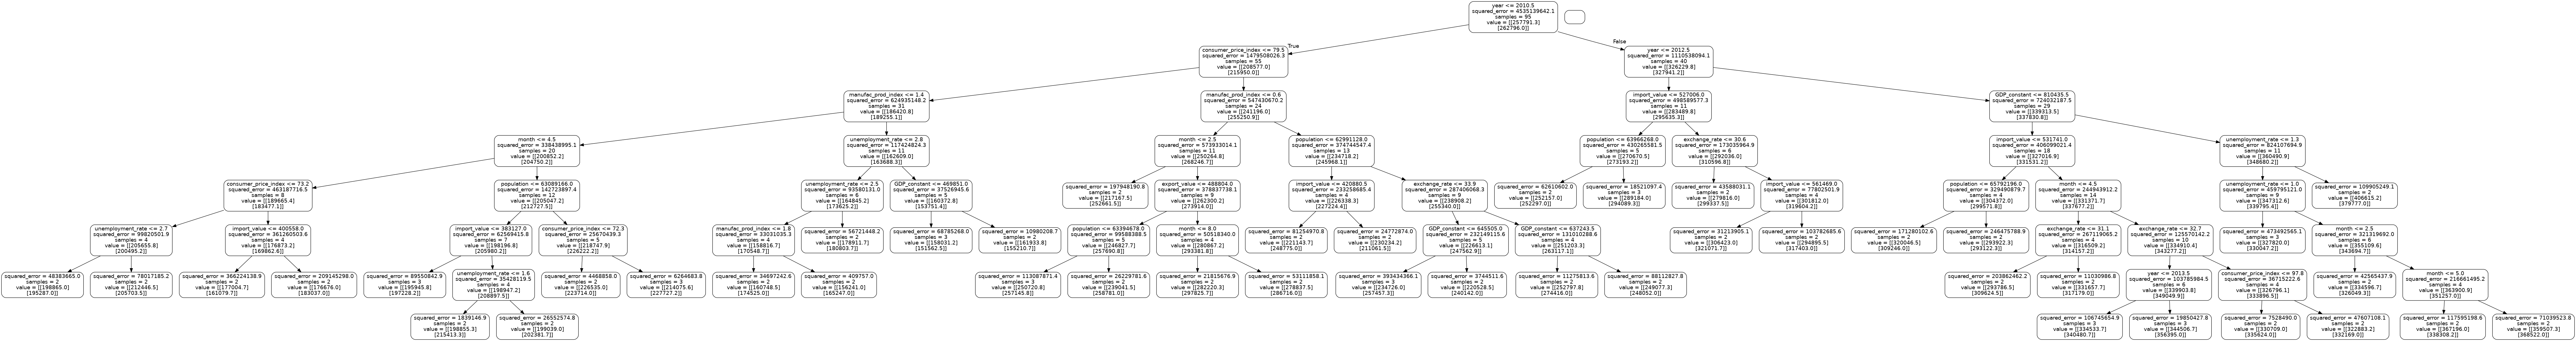

In [30]:
tree = best_model.estimators_[0]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

Image.open('tree.png')


# Forecast a future container throuhgput

In this section, a container throughput forecast model will be used to forecast a throughput in year 2022-2027. Features used in this section are 

In [31]:
historical_features_df = features_df.tail(48)
historical_features_df = historical_features_df.drop(['inflation_percentage_change', 'interest_rate'], axis=1)
historical_features = np.array(historical_features_df)

future_forecast = best_model.predict(historical_features)
# future_forecast.shape
# Merged forecast result with year and month
merged_forecast = np.c_[np.array([[i]*12 for i in range(2022,2026)]).flatten(), 
           [1,2,3,4,5,6,7,8,9,10,11,12]*4, future_forecast]


future_forecast_df = pd.DataFrame(data=merged_forecast, columns=['year','month','inbound','outbound'])
future_forecast_df['year'] = future_forecast_df['year'].apply(int)
future_forecast_df['month'] = future_forecast_df['month'].apply(int)
future_forecast_df.to_csv('future_forcast.csv')

future_forecast_df

,year,month,inbound,outbound
0,2022,1,357896.400678,350765.928810
1,2022,2,363017.531805,354572.076513
2,2022,3,353731.090102,349534.694866
3,2022,4,353828.920589,350456.302567
4,2022,5,354021.314008,351562.279664
5,2022,6,353239.593283,351867.521363
6,2022,7,350113.606640,351827.955406
7,2022,8,350648.490476,351850.631406
8,2022,9,350558.534023,352044.755293
9,2022,10,351623.394575,350755.711455


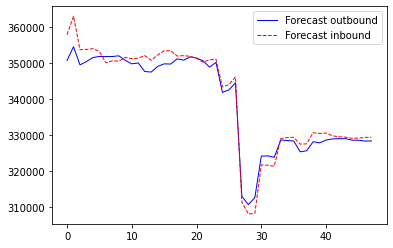

In [32]:
fig, ax = plt.subplots()

ax.plot(np.arange(0,future_forecast_df['year'].count()), future_forecast_df['outbound'], 'b', linewidth=1.0, label='Forecast outbound')
ax.plot(np.arange(0,future_forecast_df['year'].count()), future_forecast_df['inbound'], 'r--', linewidth=1.0, label='Forecast inbound')
ax.legend()
plt.show()
# fig.savefig('forecast_vs_actual_outbound.png')

# Forecast with predicted features for year 2022 to 2025

In [33]:
column = features_df.columns
future_features_forcast_df = pd.DataFrame(data = [[2022,12,9314894,10750458,9514551,0.062,0.6,103.1,70.08,1.5,34.42,106.0],
                                                  [2023,12,9706119,11212728,9857074,2.8,1.0,106.8,70.18,1.4,33,110.2],
                                                  [2024,12,9997303,11638811,10054216,2.5,1.3,109.4,70.27,1.0,32,114.8],
                                                  [2025,12,10197249,12022892,10255300,2.2,1.5,112.2,70.33,1.0,32,115.1]
                                                 ], columns=column)
future_features_forcast_df

,year,month,export_value,GDP_constant,import_value,inflation_percentage_change,interest_rate,manufac_prod_index,population,unemployment_rate,exchange_rate,consumer_price_index
0,2022,12,9314894,10750458,9514551,0.062,0.6,103.1,70.08,1.5,34.42,106.0
1,2023,12,9706119,11212728,9857074,2.800,1.0,106.8,70.18,1.4,33.00,110.2
2,2024,12,9997303,11638811,10054216,2.500,1.3,109.4,70.27,1.0,32.00,114.8
3,2025,12,10197249,12022892,10255300,2.200,1.5,112.2,70.33,1.0,32.00,115.1


In [34]:
future_features_forcast_df = future_features_forcast_df.drop(['inflation_percentage_change', 'interest_rate'], axis=1)
features = np.array(future_features_forcast_df)


new_forecast = best_model.predict(features)

In [35]:
new_merged_forecast = np.c_[np.array([i for i in range(2022,2026)]), 
           [12]*4, new_forecast]


new_df = pd.DataFrame(data=new_merged_forecast, columns=['year','month','inbound','outbound'])
new_df['year'] = new_df['year'].apply(int)
new_df['month'] = new_df['month'].apply(int)
# new_df.to_csv('future_forcast.csv')

new_df

,year,month,inbound,outbound
0,2022,12,322231.121353,324115.999352
1,2023,12,321915.089272,324197.847449
2,2024,12,320497.425192,325771.602999
3,2025,12,320497.425192,325771.602999


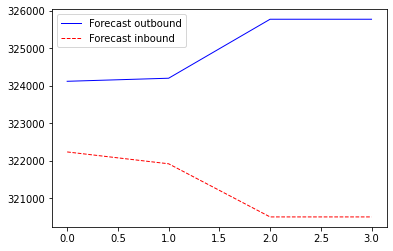

In [36]:
fig, ax = plt.subplots()

ax.plot(np.arange(0,new_df['year'].count()), new_df['outbound'], 'b', linewidth=1.0, label='Forecast outbound')
ax.plot(np.arange(0,new_df['year'].count()), new_df['inbound'], 'r--', linewidth=1.0, label='Forecast inbound')
ax.legend()
plt.show()